In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU, Dropout
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
turbo_train = pd.read_csv('/content/drive/MyDrive/NASAturbofan/train_FD001.txt', sep='\s+',header=None, index_col=False)
turbo_test = pd.read_csv('/content/drive/MyDrive/NASAturbofan/test_FD001.txt', sep='\s+',header=None, index_col=False)
y_RUL = pd.read_csv('/content/drive/MyDrive/NASAturbofan/RUL_FD001.txt', sep='\s+',header=None, index_col=False)

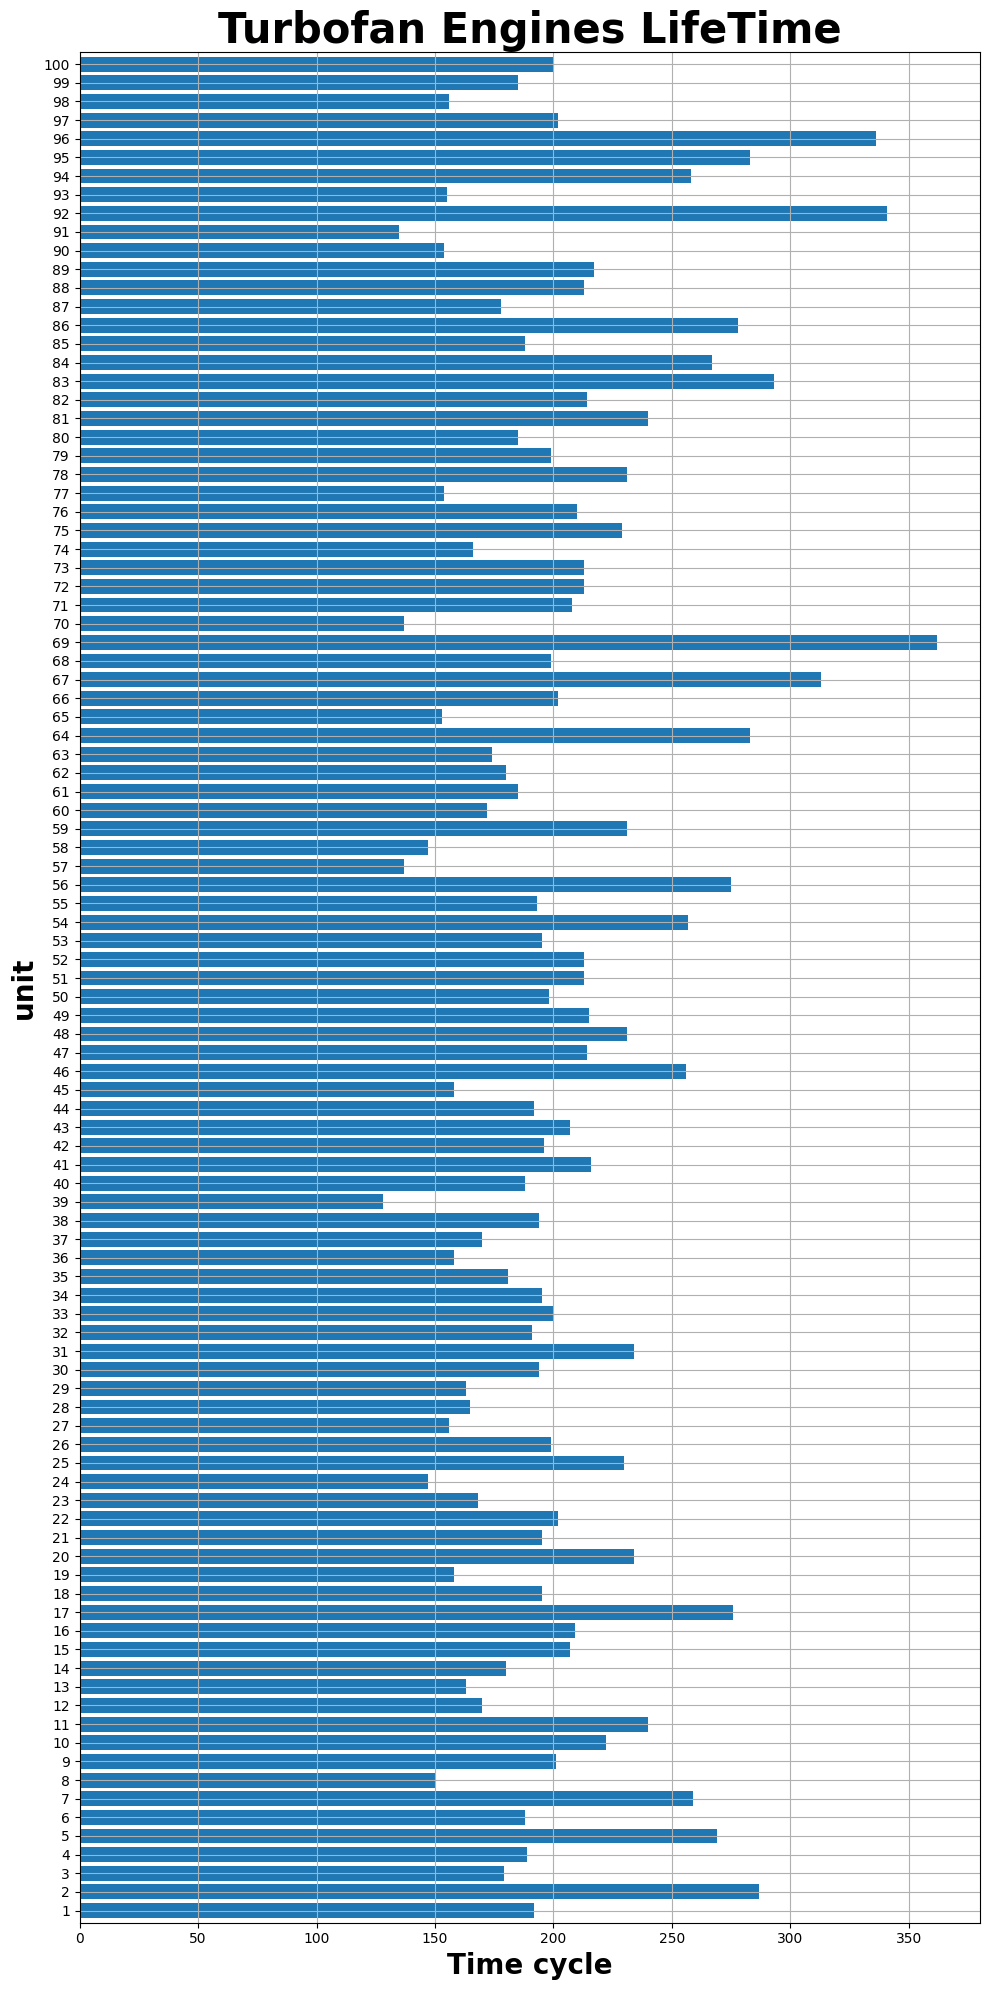

In [3]:
max_time_cycles=turbo_train.groupby(0).max()
plt.figure(figsize=(10,20))
ax=max_time_cycles[1].plot(kind='barh',width=0.8, stacked=True,align='center')
plt.title('Turbofan Engines LifeTime',fontweight='bold',size=30)
plt.xlabel('Time cycle',fontweight='bold',size=20)
plt.xticks(size=10)
plt.ylabel('unit',fontweight='bold',size=20)
plt.yticks(size=10)
plt.grid(True)
plt.tight_layout()
plt.show()

Text(0.5, 9.444444444444459, 'Max Time Cycle')

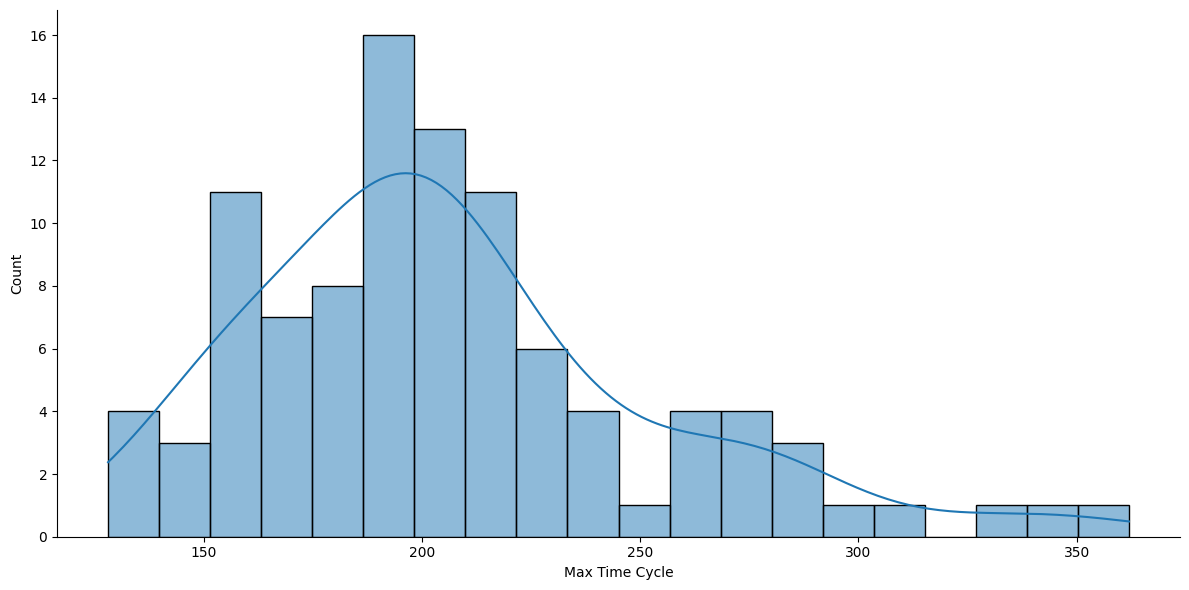

In [4]:
sns.displot(max_time_cycles[1],kde=True,bins=20,height=6,aspect=2)
plt.xlabel('Max Time Cycle')

In [5]:
turbofan = pd.concat([turbo_train, turbo_test])
display(turbofan)

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,520.69,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,521.05,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,521.18,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,521.33,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699


In [6]:
def add_RUL_column(df):
    train_grouped_by_unit = df.groupby(by=0)
    max_time_cycles = train_grouped_by_unit[1].max()
    merged = df.merge(max_time_cycles.to_frame(name='max_time_cycle'), left_on=0,right_index=True)
    merged["RUL"] = merged["max_time_cycle"] - merged[1]
    merged = merged.drop("max_time_cycle", axis=1)
    return merged

In [7]:
turbofan= add_RUL_column(turbofan)

In [8]:
turbofan

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974,6
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771,5
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051,4
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699,3


In [ ]:
turbofan.dtypes

0        int64
1        int64
2      float64
3      float64
4      float64
5      float64
6      float64
7      float64
8      float64
9      float64
10     float64
11     float64
12     float64
13     float64
14     float64
15     float64
16     float64
17     float64
18     float64
19     float64
20     float64
21       int64
22       int64
23     float64
24     float64
25     float64
RUL      int64
dtype: object

In [ ]:
turbofan.isna().sum()

0      0
1      0
2      0
3      0
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11     0
12     0
13     0
14     0
15     0
16     0
17     0
18     0
19     0
20     0
21     0
22     0
23     0
24     0
25     0
RUL    0
dtype: int64

<Axes: >

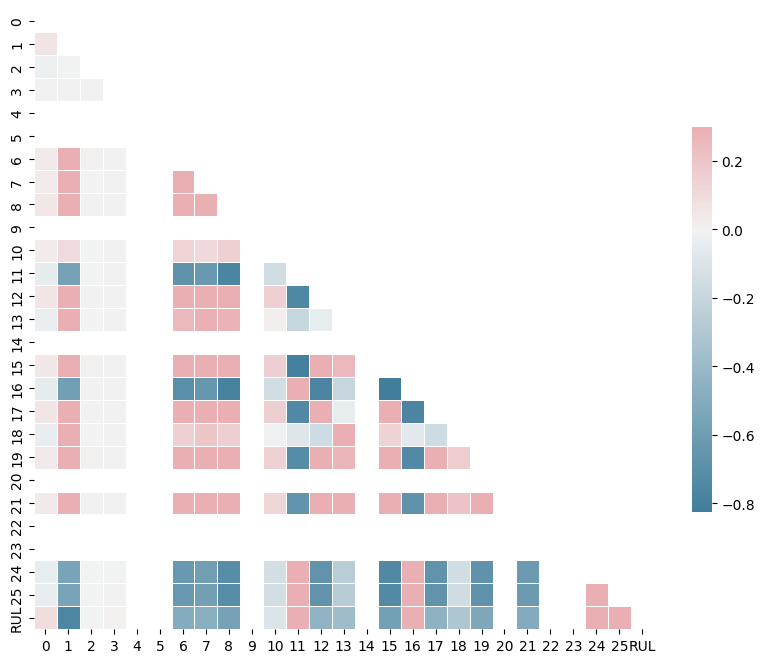

In [9]:
corr = turbofan.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(230, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})

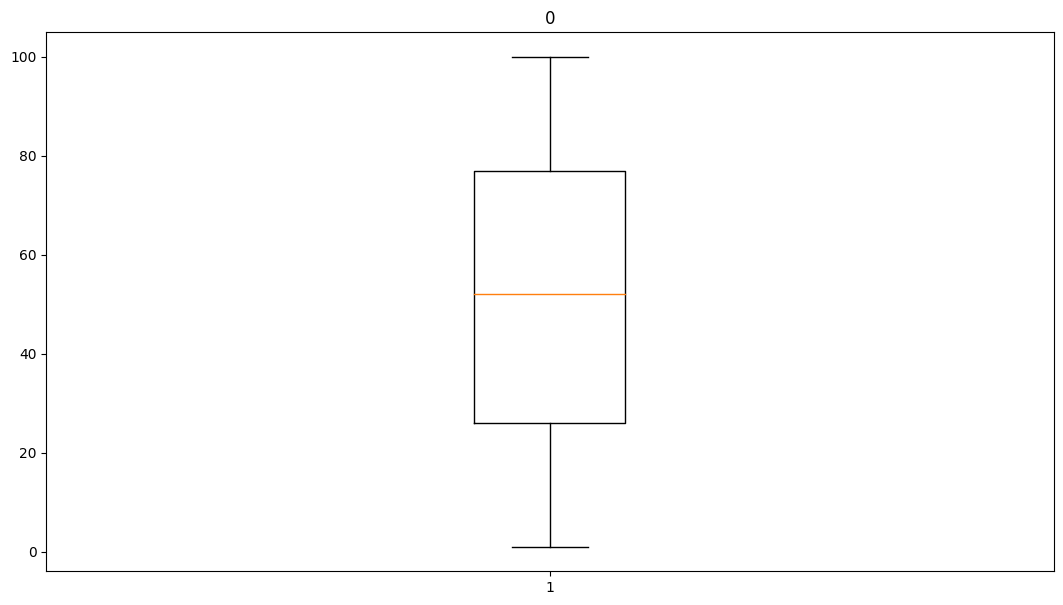

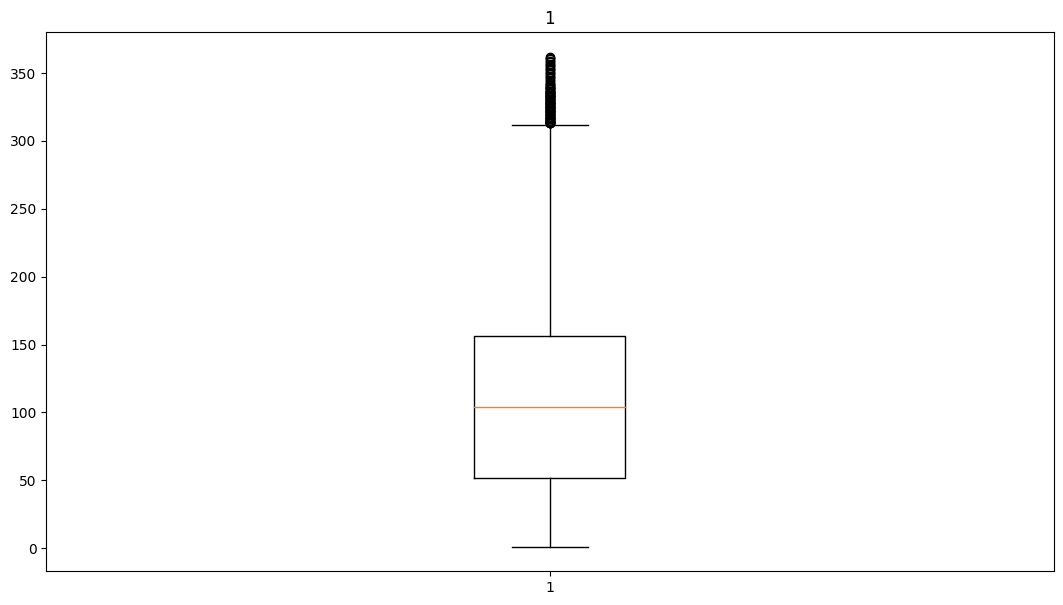

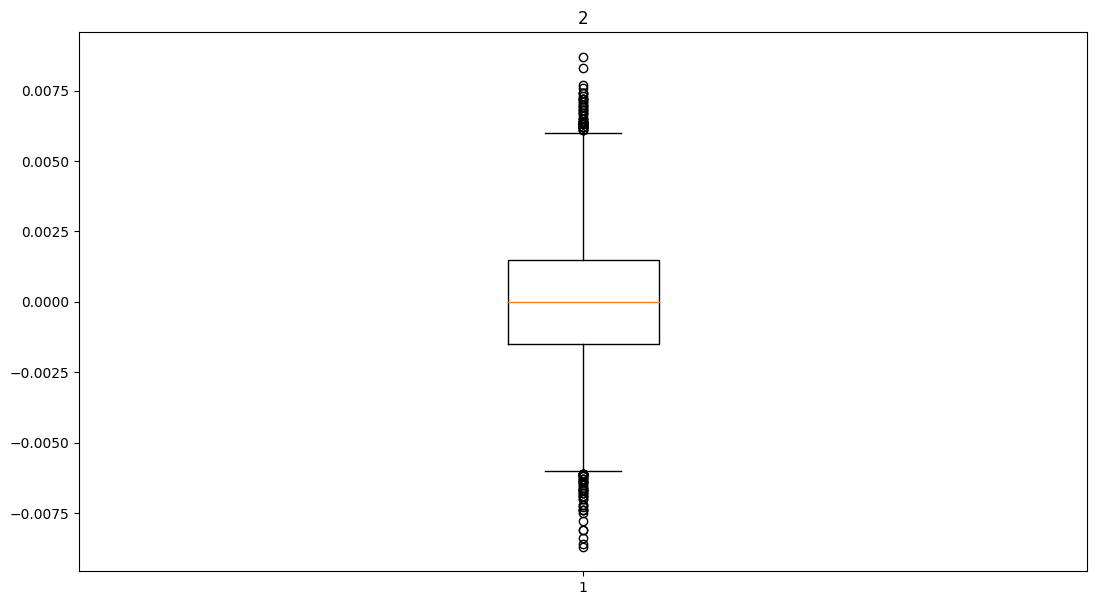

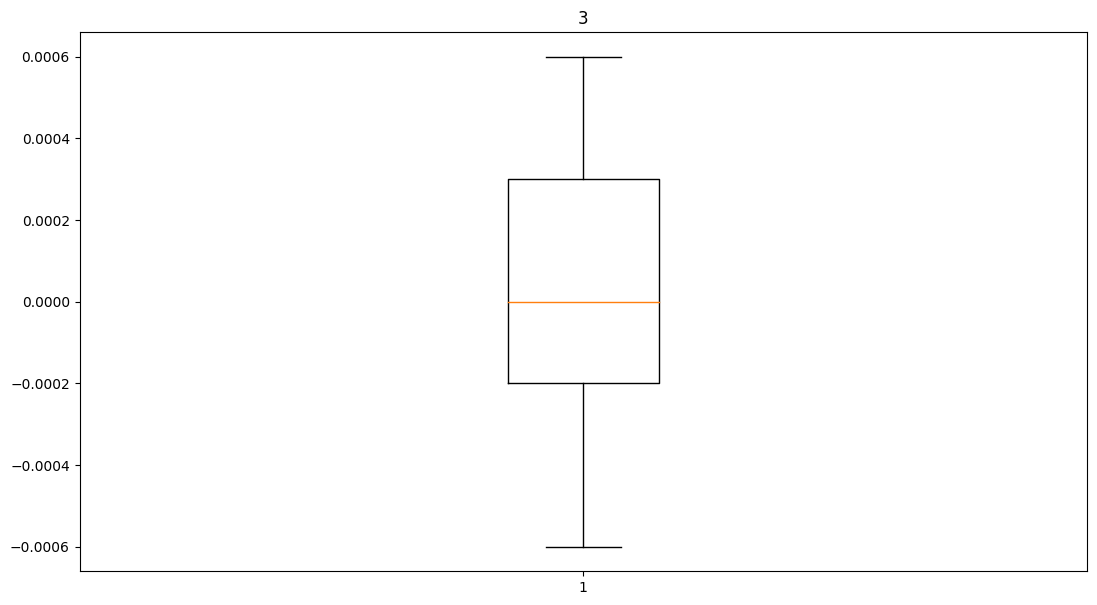

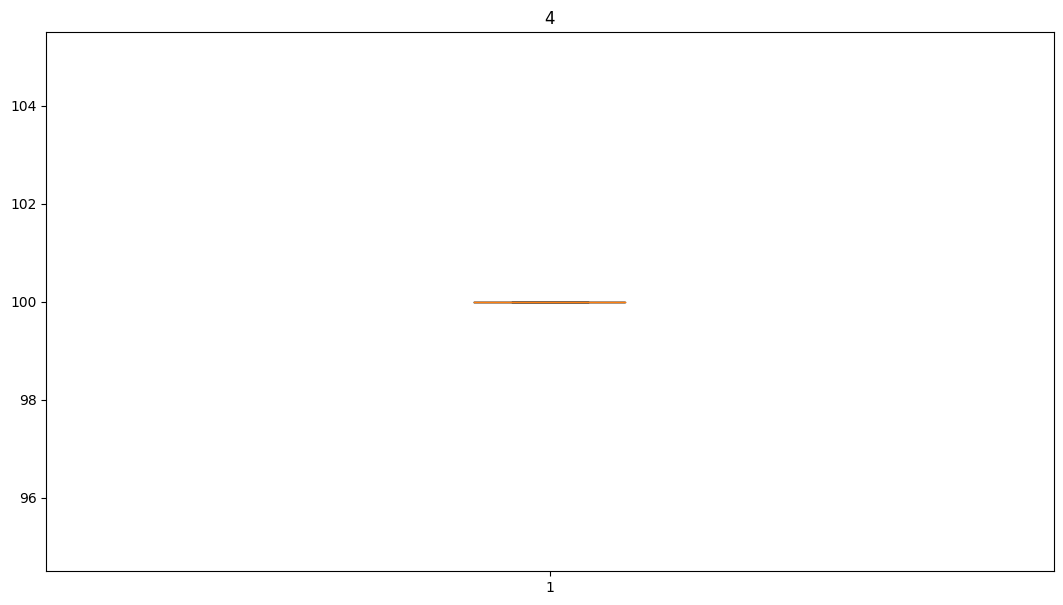

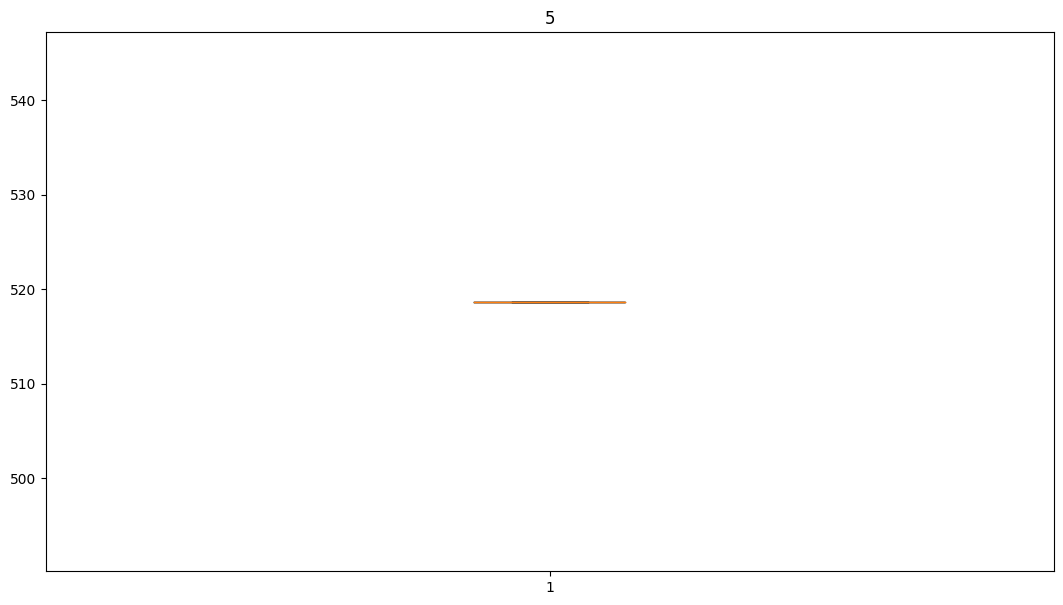

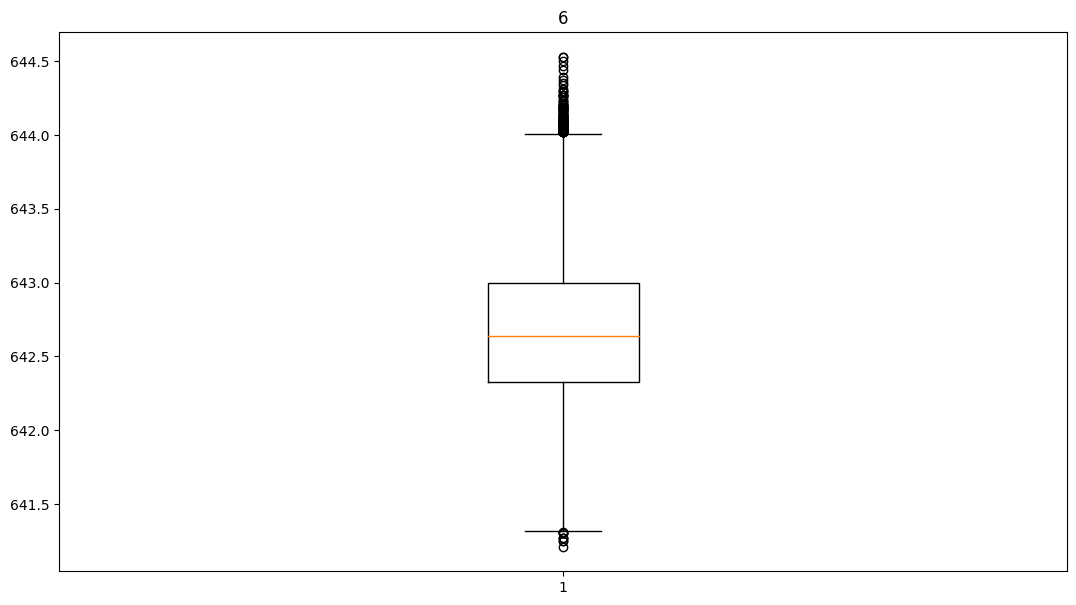

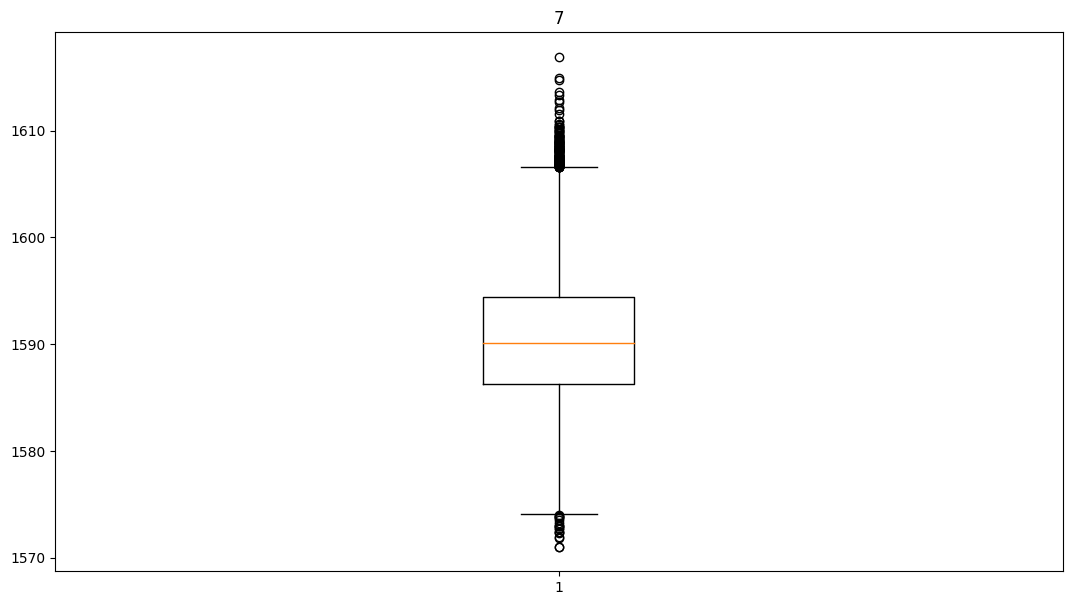

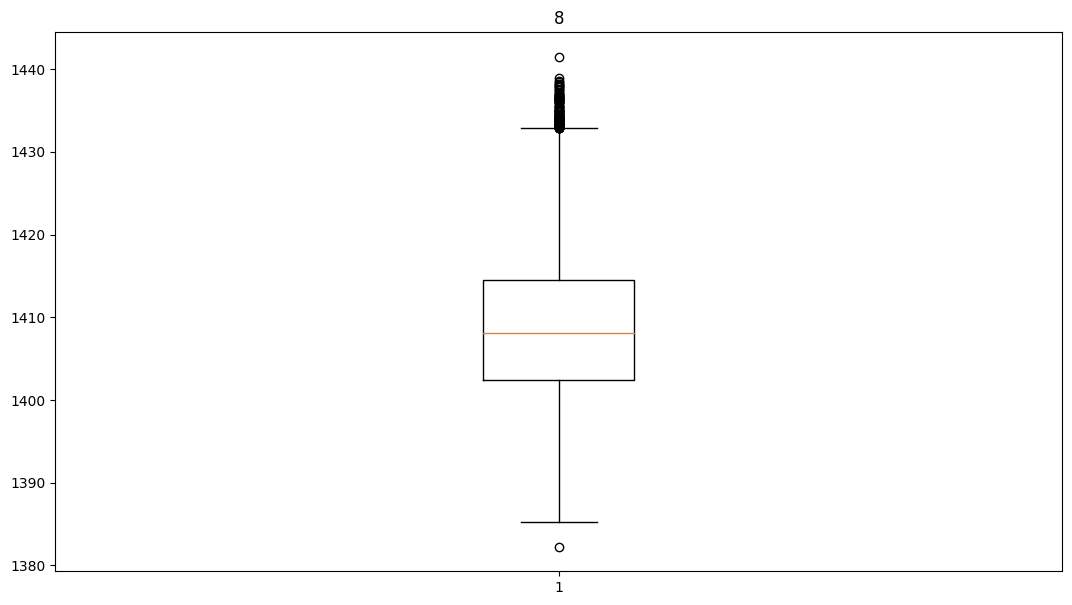

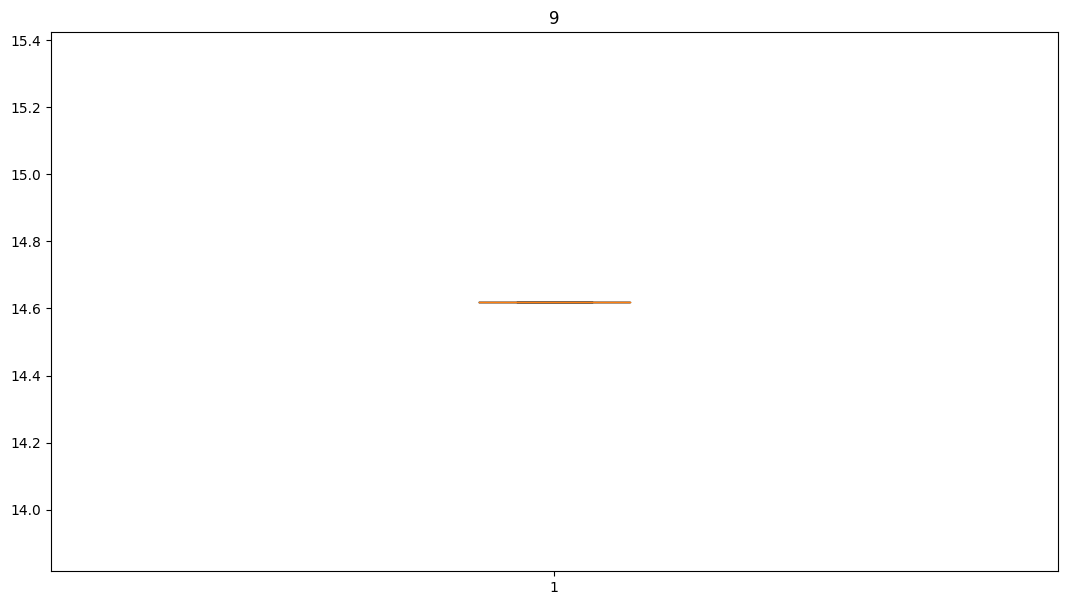

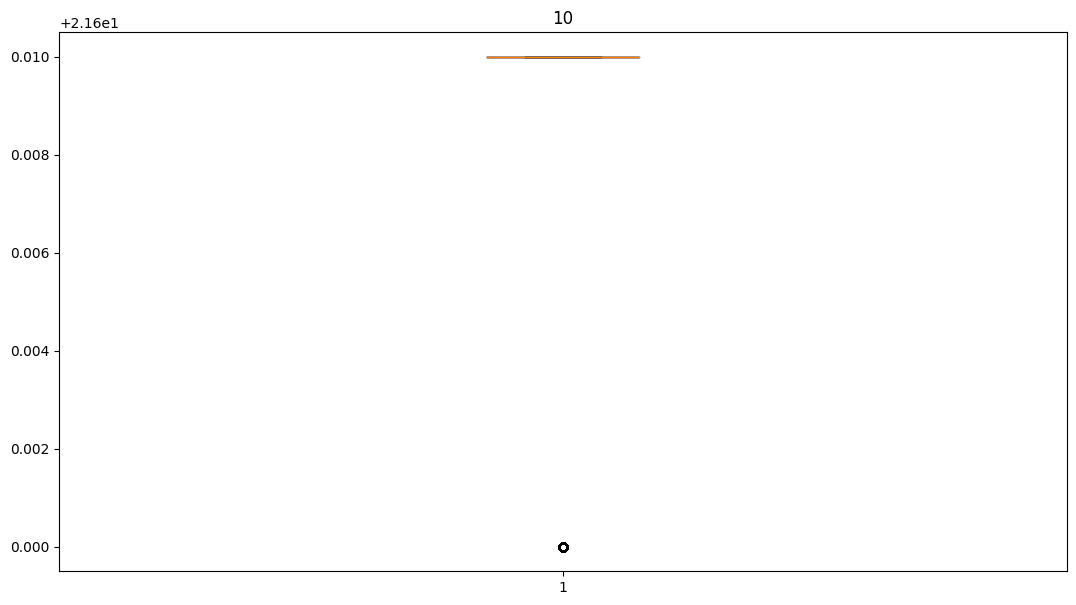

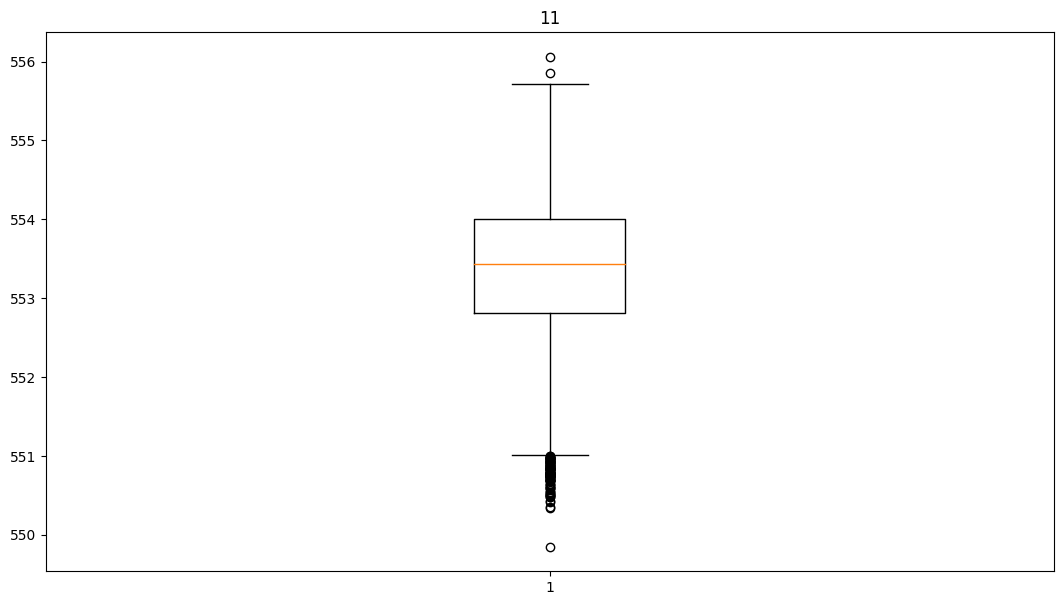

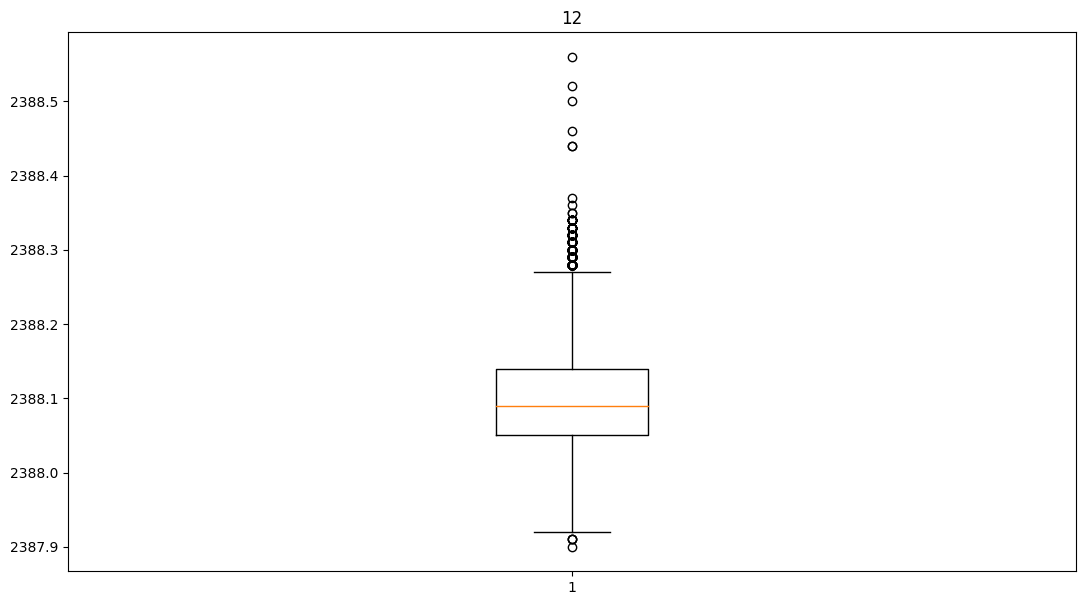

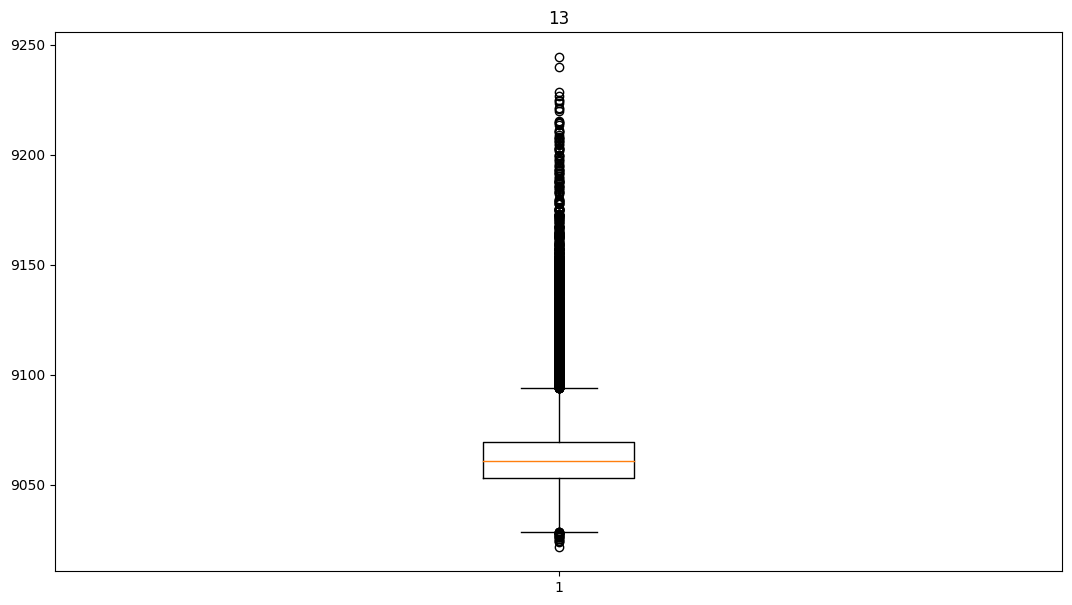

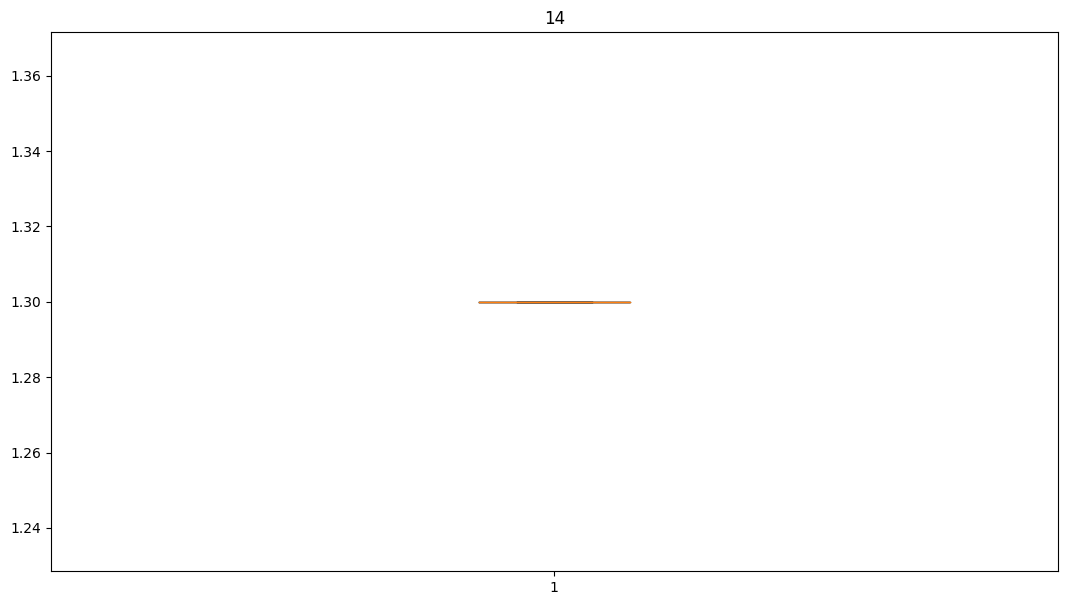

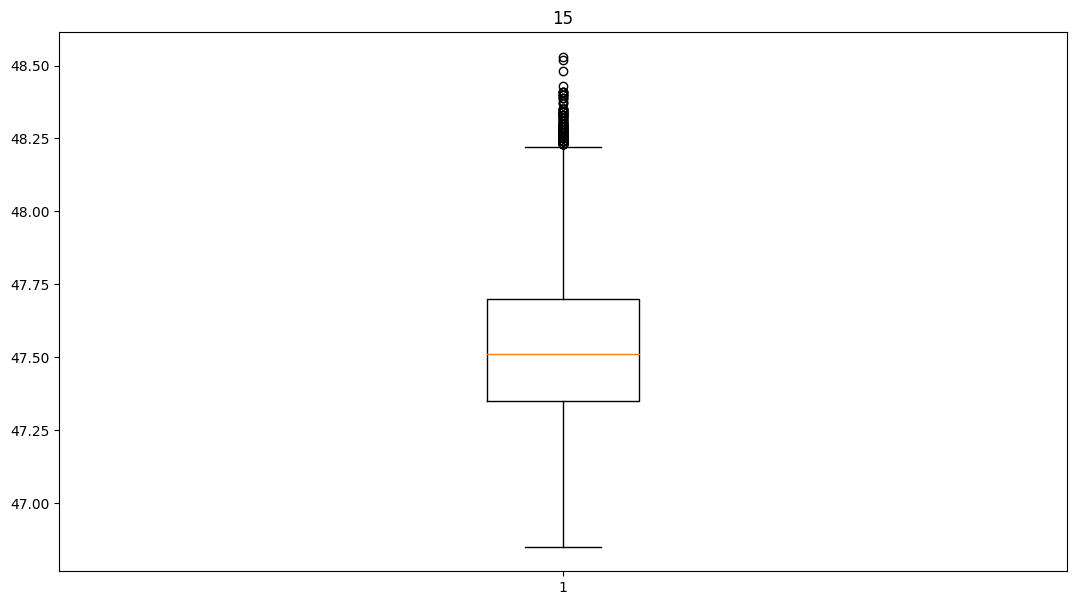

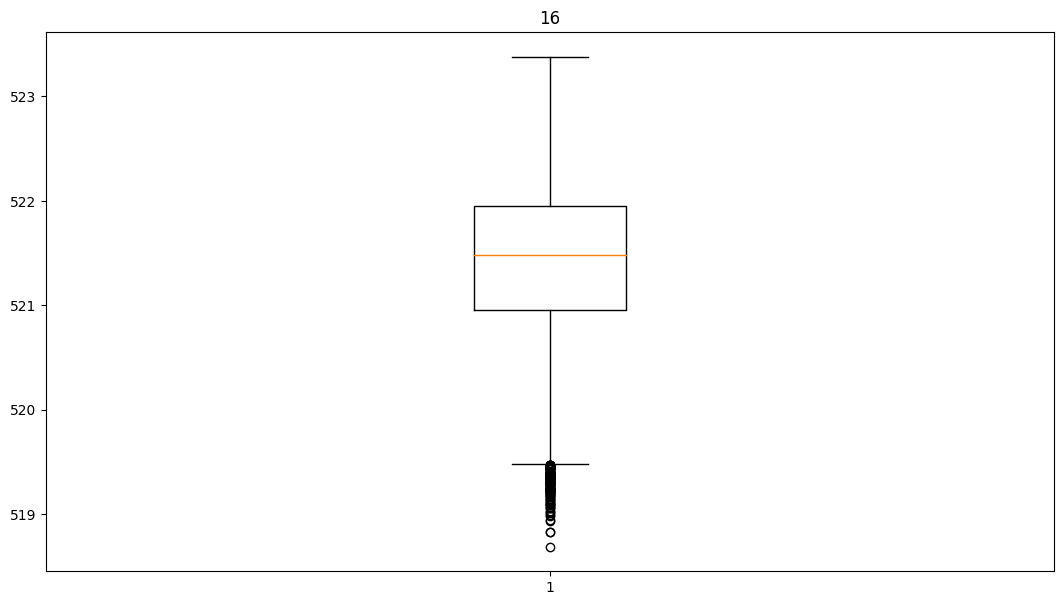

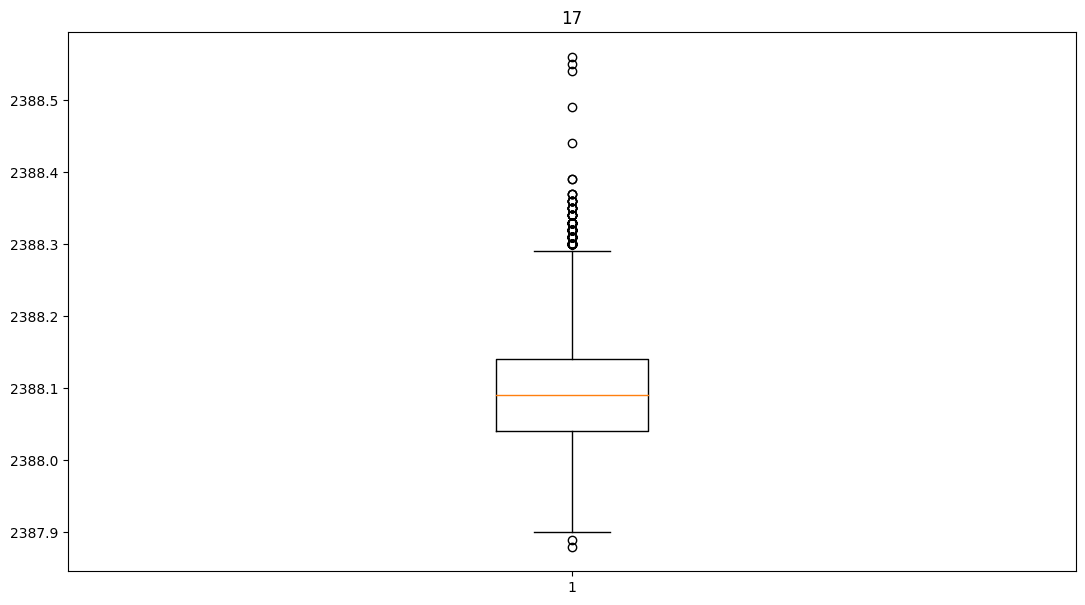

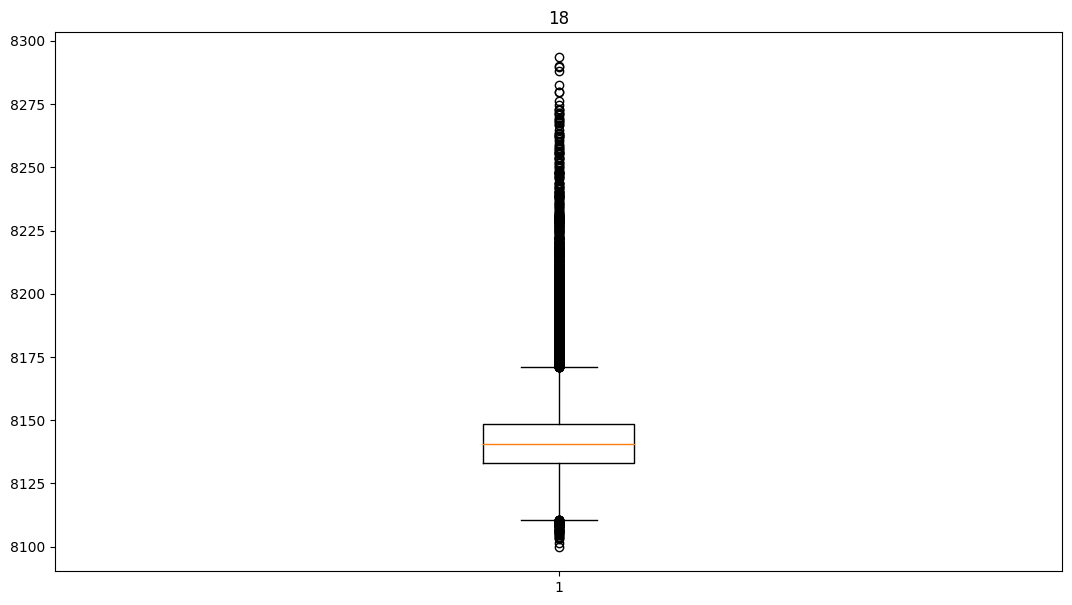

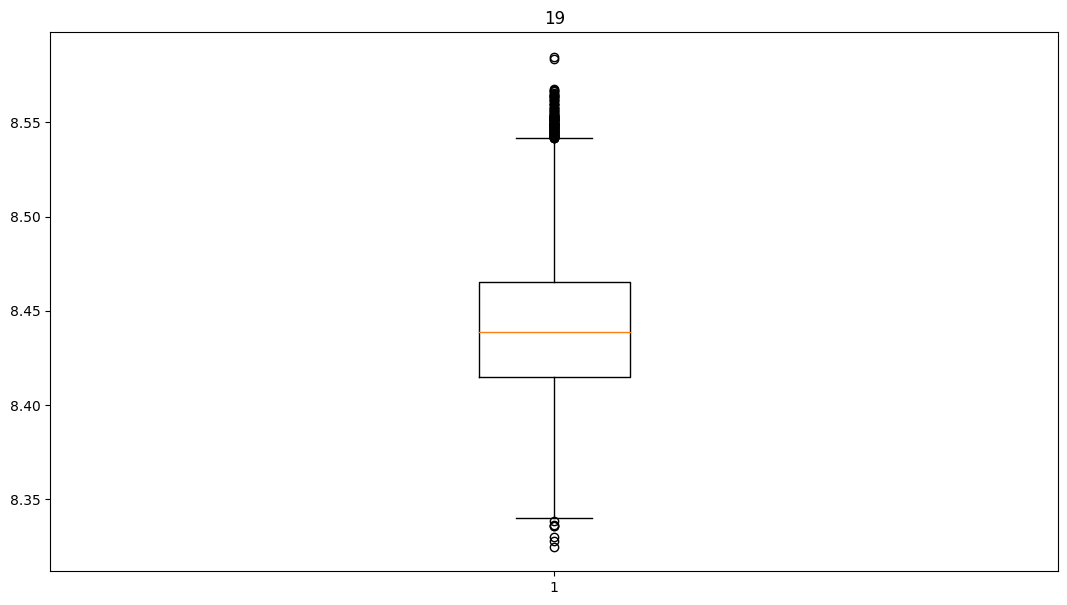

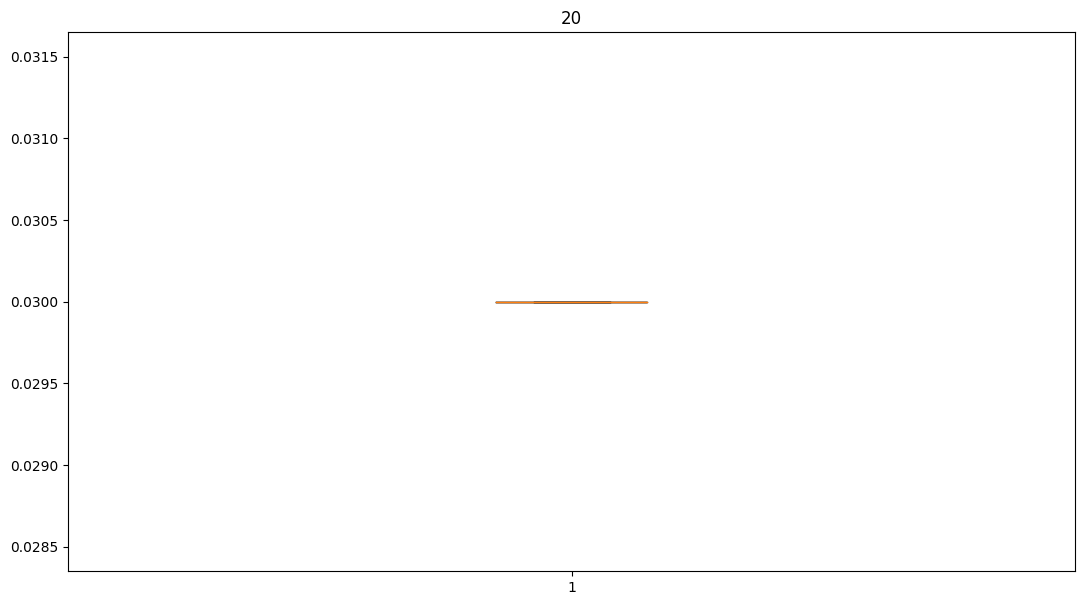

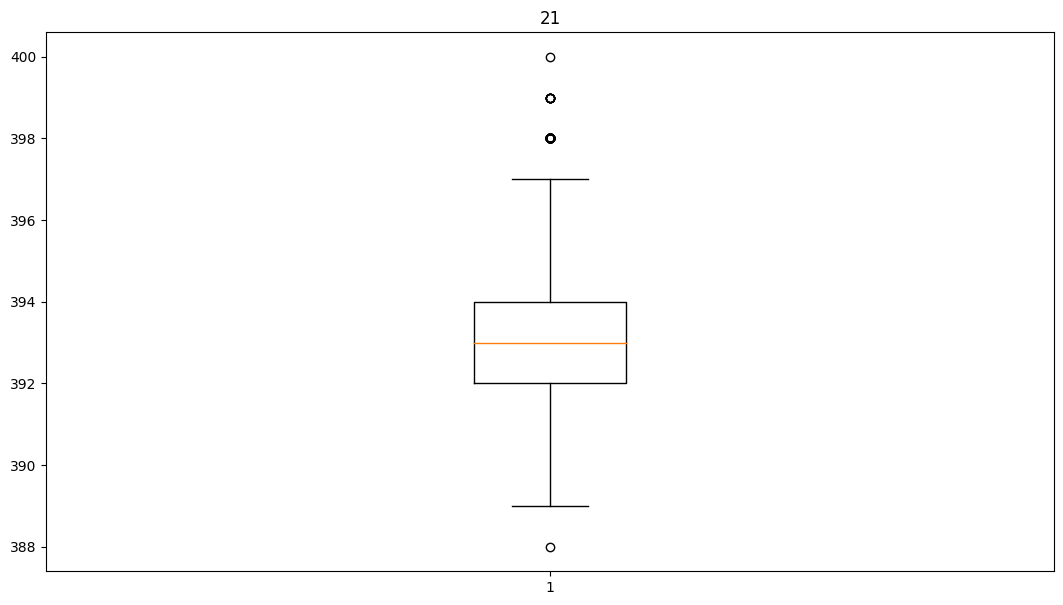

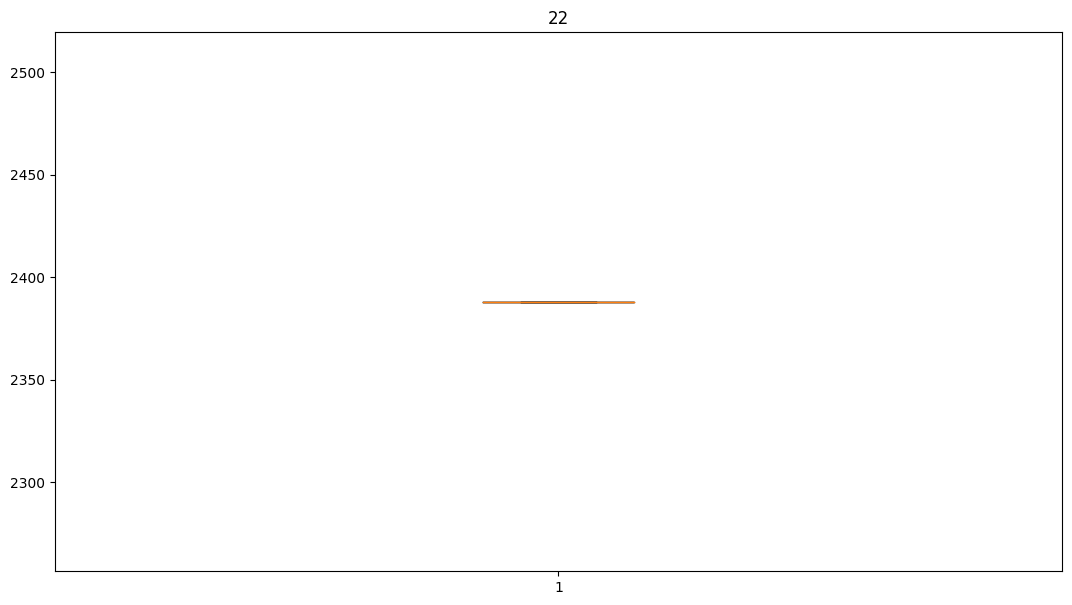

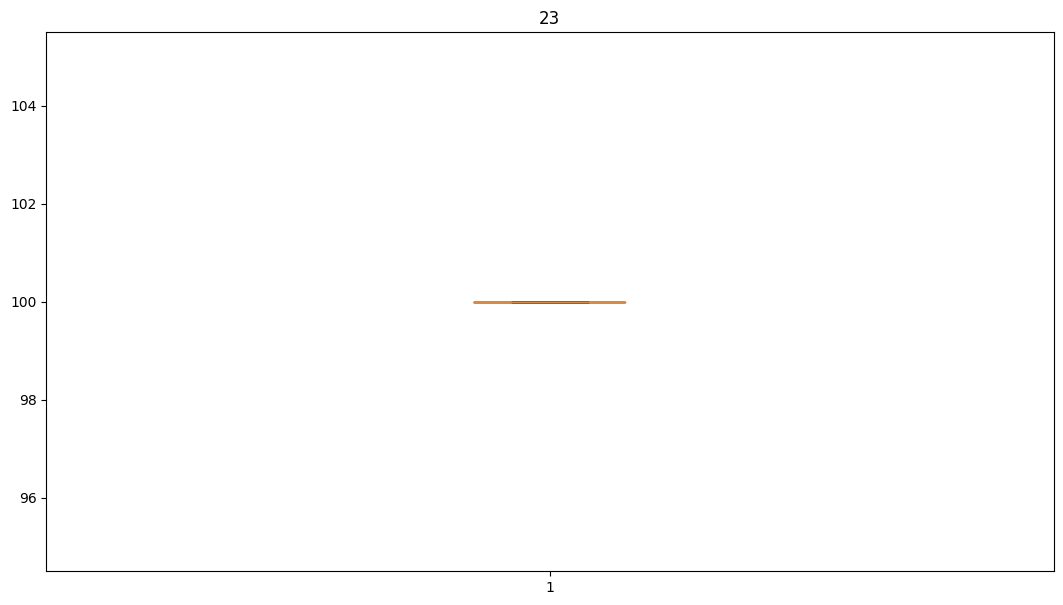

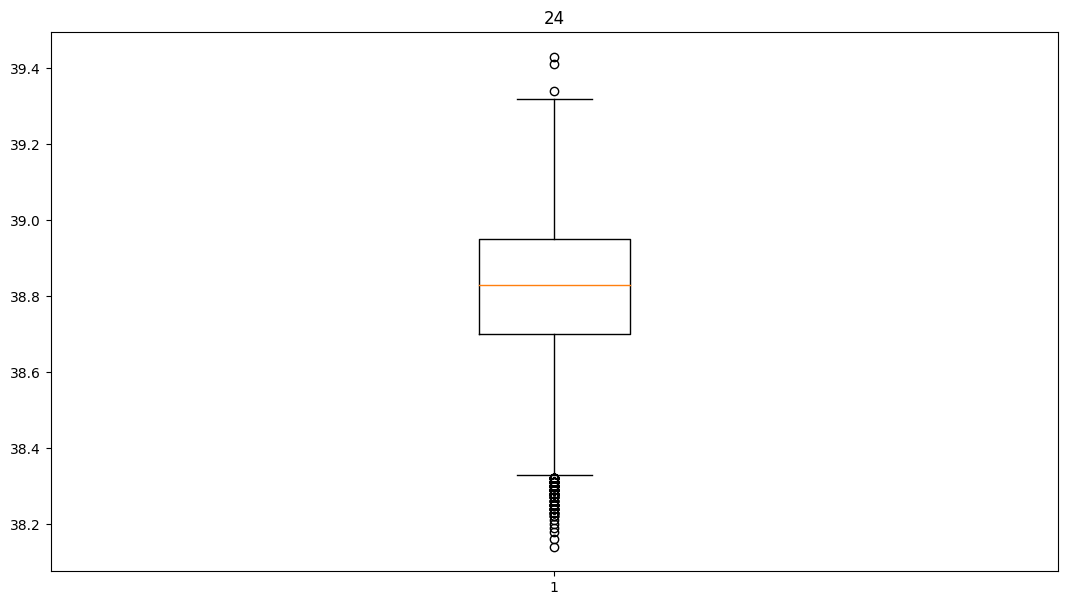

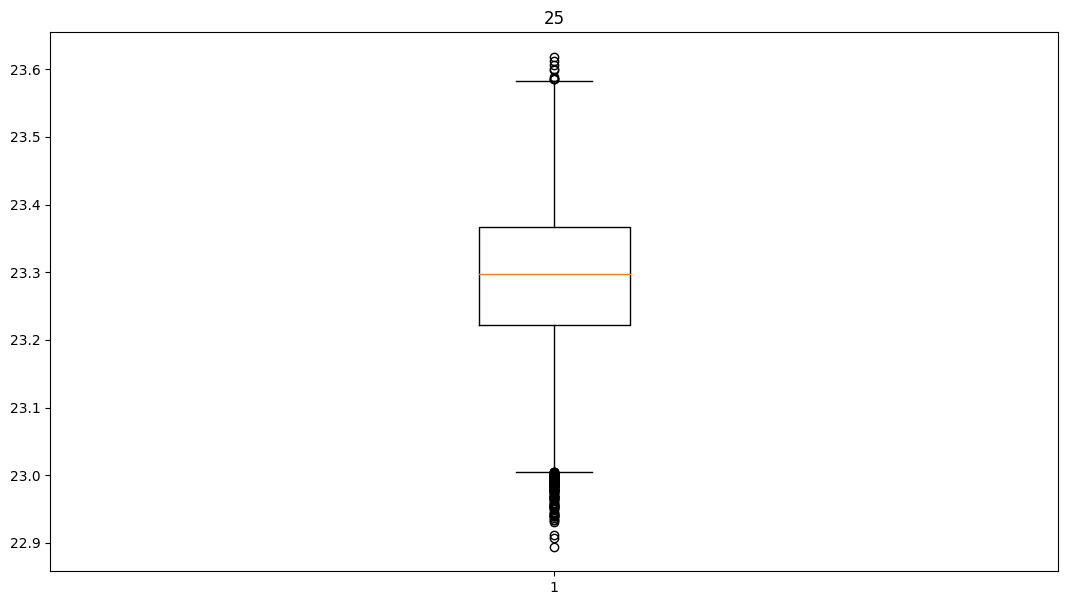

In [10]:
for x in turbo_train.columns:
    plt.figure(figsize=(13,7))
    plt.boxplot(turbo_train[x])
    plt.title(x)
    plt.show()

In [11]:
turbofan.drop(turbofan.columns[[4, 5, 9, 10, 14, 20, 22, 23]], axis=1, inplace=True)
turbofan

,0,1,2,3,6,7,8,11,12,13,15,16,17,18,19,21,24,25,RUL
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,643.24,1599.45,1415.79,553.41,2388.02,9142.37,47.69,520.69,2388.00,8213.28,8.4715,394,38.65,23.1974,6
13092,100,195,-0.0011,-0.0001,643.22,1595.69,1422.05,553.22,2388.05,9140.68,47.60,521.05,2388.09,8210.85,8.4512,395,38.57,23.2771,5
13093,100,196,-0.0006,-0.0003,643.44,1593.15,1406.82,553.04,2388.11,9146.81,47.57,521.18,2388.04,8217.24,8.4569,395,38.62,23.2051,4
13094,100,197,-0.0038,0.0001,643.26,1594.99,1419.36,553.37,2388.07,9148.85,47.61,521.33,2388.08,8220.48,8.4711,395,38.66,23.2699,3


In [12]:
X=turbofan.iloc[:, :-1]
X

,0,1,2,3,6,7,8,11,12,13,15,16,17,18,19,21,24,25
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,643.24,1599.45,1415.79,553.41,2388.02,9142.37,47.69,520.69,2388.00,8213.28,8.4715,394,38.65,23.1974
13092,100,195,-0.0011,-0.0001,643.22,1595.69,1422.05,553.22,2388.05,9140.68,47.60,521.05,2388.09,8210.85,8.4512,395,38.57,23.2771
13093,100,196,-0.0006,-0.0003,643.44,1593.15,1406.82,553.04,2388.11,9146.81,47.57,521.18,2388.04,8217.24,8.4569,395,38.62,23.2051
13094,100,197,-0.0038,0.0001,643.26,1594.99,1419.36,553.37,2388.07,9148.85,47.61,521.33,2388.08,8220.48,8.4711,395,38.66,23.2699


In [13]:
scaler = MinMaxScaler()
X=scaler.fit_transform(X)
X

array([[0.        , 0.        , 0.45977011, ..., 0.33333333, 0.71317829,
        0.70188578],
       [0.        , 0.00277008, 0.6091954 , ..., 0.33333333, 0.66666667,
        0.70803798],
       [0.        , 0.00554017, 0.25287356, ..., 0.16666667, 0.62790698,
        0.60184566],
       ...,
       [1.        , 0.5401662 , 0.46551724, ..., 0.58333333, 0.37209302,
        0.41580848],
       [1.        , 0.54293629, 0.2816092 , ..., 0.58333333, 0.40310078,
        0.50247425],
       [1.        , 0.54570637, 0.57471264, ..., 0.66666667, 0.43410853,
        0.38959476]])

In [14]:
y=turbofan.iloc[:, -1]
y

0        191
1        190
2        189
3        188
4        187
        ... 
13091      6
13092      5
13093      4
13094      3
13095      2
Name: RUL, Length: 33727, dtype: int64

In [15]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=42)

In [17]:
model = Sequential()
model.add(LSTM(units=50, input_shape=(X_train.shape[1], 1)))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

history=model.fit(X_train, y_train, epochs=20,
                  validation_data=(X_test, y_test))
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error on Test Data: {mse}')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                10400     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
738/738 [==============================] - 12s 13ms/step - loss: 13841.8057 - val_loss: 10719.8379
Epoch 2/20
738/738 [==============================] - 7s 10ms/step - loss: 8577.1084 - val_loss: 7094.8687
Epoch 3/20
738/738 [==============================] - 9s 12ms/step - loss: 6079.4795 - val_loss: 5435.4951
Epoch 4/20
738/738 [==============================] - 7s 10ms/step - loss: 5072.2861 - val

In [18]:
print(math.sqrt(1594.0643910823305))

39.925735949163546


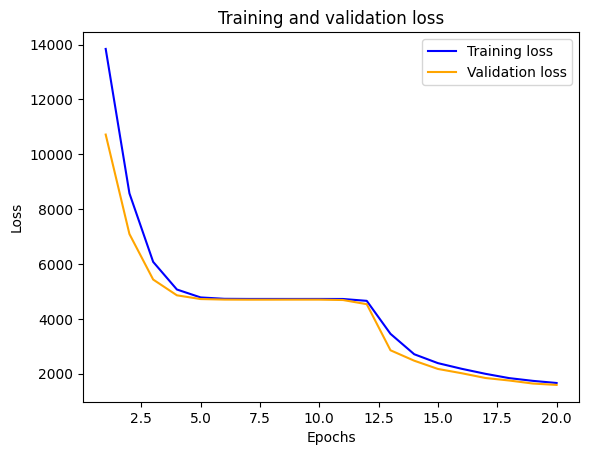

In [19]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'blue', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
model = Sequential()
model.add(GRU(units=50, input_shape=(X_train.shape[1], 1)))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()
history=model.fit(X_train, y_train, epochs=20,
                  validation_data=(X_test, y_test))

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error on Test Data: {mse}')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 50)                7950      
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 8001 (31.25 KB)
Trainable params: 8001 (31.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
738/738 [==============================] - 11s 13ms/step - loss: 13916.0078 - val_loss: 10770.7178
Epoch 2/20
738/738 [==============================] - 7s 10ms/step - loss: 8610.0098 - val_loss: 7118.1138
Epoch 3/20
738/738 [==============================] - 9s 12ms/step - loss: 6098.6187 - val_loss: 5450.5337
Epoch 4/20
738/738 [==============================] - 7s 10ms/step - loss: 5083.7339 - val_l

In [21]:
print(math.sqrt(1532.2140087621985))

39.143505320323555


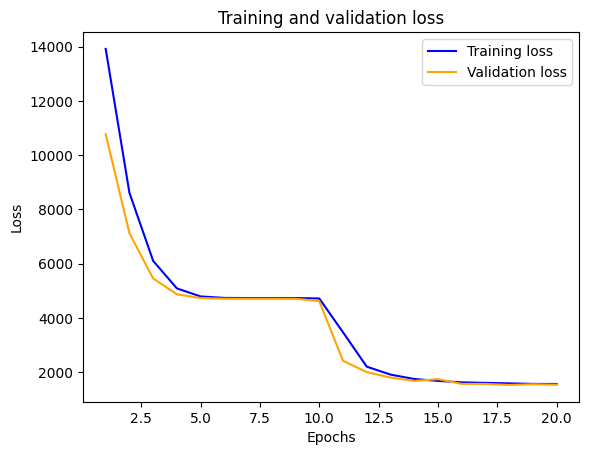

In [22]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'blue', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
model = Sequential()
model.add(LSTM(units=50, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.1))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()
history=model.fit(X_train, y_train, epochs=20,
                  validation_data=(X_test, y_test))
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error on Test Data: {mse}')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50)                10400     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
738/738 [==============================] - 12s 12ms/step - loss: 13750.2227 - val_loss: 10713.3535
Epoch 2/20
738/738 [==============================] - 7s 10ms/step - loss: 8614.7461 - val_loss: 7152.4072
Epoch 3/20
738/738 [==============================] - 9s 12ms/ste

In [24]:
print(math.sqrt(1641.1057786596543))

40.510563790937965


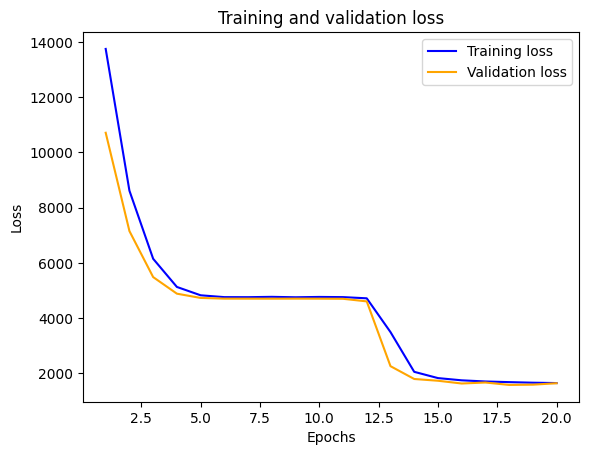

In [25]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'blue', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [47]:
model = Sequential()
model.add(GRU(units=50, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.1))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()
history=model.fit(X_train, y_train, epochs=20,
                  validation_data=(X_test, y_test))

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error on Test Data: {mse}')

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_15 (GRU)                (None, 50)                7950      
                                                                 
 dropout_24 (Dropout)        (None, 50)                0         
                                                                 
 dense_13 (Dense)            (None, 1)                 51        
                                                                 
Total params: 8001 (31.25 KB)
Trainable params: 8001 (31.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
738/738 [==============================] - 13s 13ms/step - loss: 13736.1357 - val_loss: 10659.9355
Epoch 2/20
738/738 [==============================] - 15s 20ms/step - loss: 8567.6455 - val_loss: 7093.2754
Epoch 3/20
738/738 [==============================] - 11s 14ms/st

In [48]:
print(math.sqrt(1433.9982022338565))

37.86816872036271


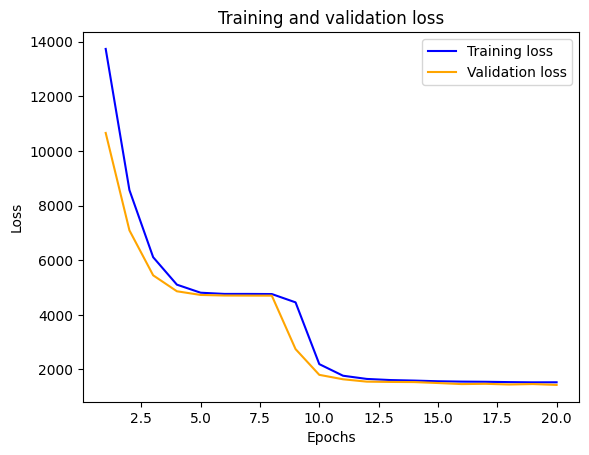

In [49]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'blue', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [50]:
model = Sequential()
model.add(GRU(units=90, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.1))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()
history=model.fit(X_train, y_train, epochs=20,
                  validation_data=(X_test, y_test))

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error on Test Data: {mse}')

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_16 (GRU)                (None, 90)                25110     
                                                                 
 dropout_25 (Dropout)        (None, 90)                0         
                                                                 
 dense_14 (Dense)            (None, 1)                 91        
                                                                 
Total params: 25201 (98.44 KB)
Trainable params: 25201 (98.44 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
738/738 [==============================] - 15s 17ms/step - loss: 11382.7695 - val_loss: 7460.6226
Epoch 2/20
738/738 [==============================] - 13s 18ms/step - loss: 5880.0649 - val_loss: 5043.1978
Epoch 3/20
738/738 [==============================] - 11s 16ms/s

In [51]:
print(math.sqrt(1477.767339579336))

38.44173954934058


##2 LSTM 2 dropout

In [28]:
model = Sequential()
model.add(LSTM(units=50, input_shape=(X_train.shape[1], 1), return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(units=50))
model.add(Dropout(0.1))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()
history=model.fit(X_train, y_train, epochs=20,
                  validation_data=(X_test, y_test))

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error on Test Data: {mse}')

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 18, 50)            10400     
                                                                 
 dropout_2 (Dropout)         (None, 18, 50)            0         
                                                                 
 lstm_4 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
738/7

In [29]:
print(math.sqrt(1960.9918150803248))

44.28308723519991


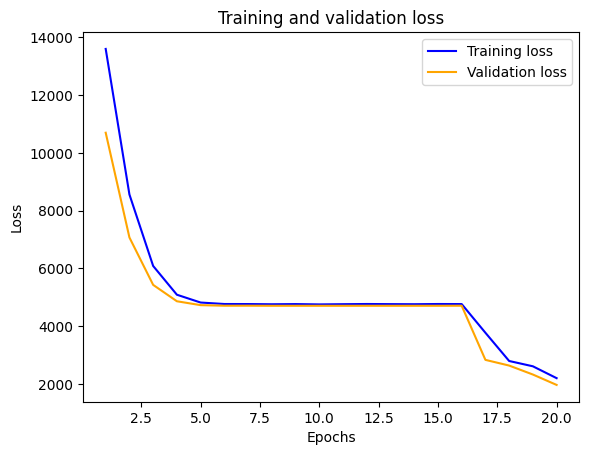

In [30]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'blue', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [36]:
model = Sequential()
model.add(GRU(units=50, input_shape=(X_train.shape[1], 1), return_sequences=True))
model.add(Dropout(0.1))
model.add(GRU(units=50))
model.add(Dropout(0.1))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()
history=model.fit(X_train, y_train, epochs=20,
                  validation_data=(X_test, y_test))
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error on Test Data: {mse}')

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 18, 50)            7950      
                                                                 
 dropout_6 (Dropout)         (None, 18, 50)            0         
                                                                 
 gru_5 (GRU)                 (None, 50)                15300     
                                                                 
 dropout_7 (Dropout)         (None, 50)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 51        
                                                                 
Total params: 23301 (91.02 KB)
Trainable params: 23301 (91.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
738/738

In [37]:
print(math.sqrt(1659.4463011346506))

40.73630200613024


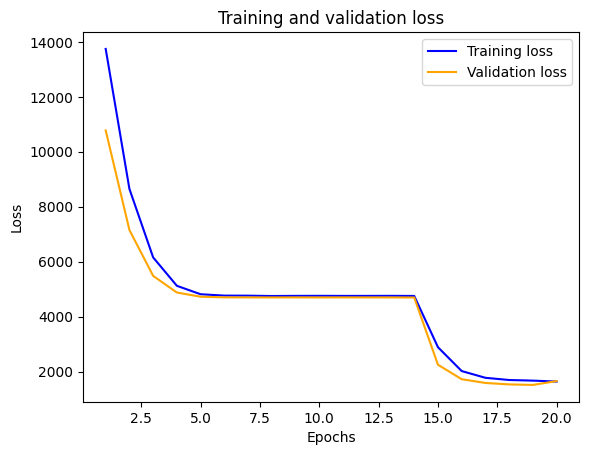

In [38]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'blue', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [39]:
model = Sequential()
model.add(LSTM(units=50, input_shape=(X_train.shape[1], 1), return_sequences=True))
model.add(Dropout(0.1))
model.add(GRU(units=50))
model.add(Dropout(0.1))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()
history=model.fit(X_train, y_train, epochs=20,
                  validation_data=(X_test, y_test))

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error on Test Data: {mse}')

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 18, 50)            10400     
                                                                 
 dropout_8 (Dropout)         (None, 18, 50)            0         
                                                                 
 gru_6 (GRU)                 (None, 50)                15300     
                                                                 
 dropout_9 (Dropout)         (None, 50)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 51        
                                                                 
Total params: 25751 (100.59 KB)
Trainable params: 25751 (100.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
738/7

In [40]:
print(math.sqrt(3067.3230869037748))

55.383418880597965


In [41]:
model = Sequential()
model.add(GRU(units=90, input_shape=(X_train.shape[1], 1), return_sequences=True))
model.add(Dropout(0.1))
model.add(GRU(units=90))
model.add(Dropout(0.1))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()
history=model.fit(X_train, y_train, epochs=20,
                  validation_data=(X_test, y_test))

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error on Test Data: {mse}')

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_7 (GRU)                 (None, 18, 90)            25110     
                                                                 
 dropout_10 (Dropout)        (None, 18, 90)            0         
                                                                 
 gru_8 (GRU)                 (None, 90)                49140     
                                                                 
 dropout_11 (Dropout)        (None, 90)                0         
                                                                 
 dense_10 (Dense)            (None, 1)                 91        
                                                                 
Total params: 74341 (290.39 KB)
Trainable params: 74341 (290.39 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
738/

In [42]:
print(math.sqrt(1455.1576958959554))

38.14652927719579


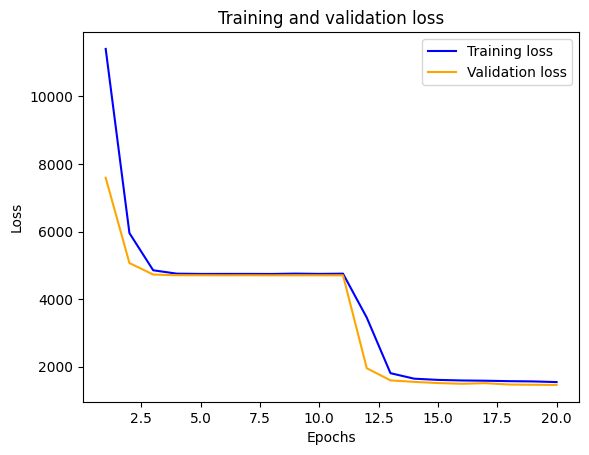

In [43]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'blue', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

6 LSTM

In [44]:
model = Sequential()
model.add(LSTM(units=50, input_shape=(X_train.shape[1], 1), return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(units=50))
model.add(Dropout(0.1))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()
history=model.fit(X_train, y_train, epochs=20,
                  validation_data=(X_test, y_test))
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error on Test Data: {mse}')

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 18, 50)            10400     
                                                                 
 dropout_12 (Dropout)        (None, 18, 50)            0         
                                                                 
 lstm_7 (LSTM)               (None, 18, 50)            20200     
                                                                 
 dropout_13 (Dropout)        (None, 18, 50)            0         
                                                                 
 lstm_8 (LSTM)               (None, 18, 50)            20200     
                                                                 
 dropout_14 (Dropout)        (None, 18, 50)            0         
                                                                 
 lstm_9 (LSTM)               (None, 18, 50)          

In [45]:
print(math.sqrt(4703.233300850175))

68.58012321985267


In [46]:
model = Sequential()
model.add(GRU(units=50, input_shape=(X_train.shape[1], 1), return_sequences=True))
model.add(Dropout(0.1))
model.add(GRU(units=50, return_sequences=True))
model.add(Dropout(0.1))
model.add(GRU(units=50, return_sequences=True))
model.add(Dropout(0.1))
model.add(GRU(units=50, return_sequences=True))
model.add(Dropout(0.1))
model.add(GRU(units=50, return_sequences=True))
model.add(Dropout(0.1))
model.add(GRU(units=50))
model.add(Dropout(0.1))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()
history=model.fit(X_train, y_train, epochs=20,
                  validation_data=(X_test, y_test))

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error on Test Data: {mse}')

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_9 (GRU)                 (None, 18, 50)            7950      
                                                                 
 dropout_18 (Dropout)        (None, 18, 50)            0         
                                                                 
 gru_10 (GRU)                (None, 18, 50)            15300     
                                                                 
 dropout_19 (Dropout)        (None, 18, 50)            0         
                                                                 
 gru_11 (GRU)                (None, 18, 50)            15300     
                                                                 
 dropout_20 (Dropout)        (None, 18, 50)            0         
                                                                 
 gru_12 (GRU)                (None, 18, 50)          

In [ ]:
print(math.sqrt(4705.530241852322))

68.59686758046844
